In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from nltk.stem.snowball import RussianStemmer
import sklearn 
import string

from sklearn.feature_extraction.text import CountVectorizer

In [2]:
MAX_FEATURES = 5000 # Максимальное кол-во признаков-слов для CountVectorizer
CAT_COLS = ['category', 'subcategory'] # факторизуемые колонки
TARGET_COLUMNS = ['title', 'description', 'attrs', ['title', 'description']] # колонки, для построения BagOfWords тиблиц
SEED = 8451 # Показатель рандома

In [3]:
data = pd.DataFrame.from_csv('data/avito_train.tsv', sep='\t')

In [4]:
data.head(1)

,category,subcategory,title,description,attrs,price,is_proved,is_blocked,phones_cnt,emails_cnt,urls_cnt,close_hours
itemid,,,,,,,,,,,,
10000010,Транспорт,Автомобили с пробегом,"Toyota Sera, 1991",Новая оригинальная линзованая оптика на ксенон...,"{""Год выпуска"":""1991"", ""Тип кузова"":""Купе"", ""П...",150000,NaN,0,0,0,0,0.03


In [5]:
train = data[:10000]
data.shape

(3995803, 12)

In [6]:
# просматриваем информацию в колонках
for column in train.columns:
    print("{: <20} {:} {: >10}".format(column, train[column].dtype, len(train[column].unique())))

category             object         10
subcategory          object         53
title                object       8542
description          object       9842
attrs                object       4405
price                int64       1344
is_proved            float64          3
is_blocked           int64          2
phones_cnt           int64          8
emails_cnt           int64          3
urls_cnt             int64          6
close_hours          float64       2124


.# по таблице определяем категориальные string колонки
cat_cols = ['category','subcategory']

import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
train[cat_cols] = train[cat_cols].apply(lambda x: pd.factorize(x)[0])

In [7]:
# %load scripts/preprocessing.py
from nltk.stem.snowball import RussianStemmer
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import CountVectorizer

# стемминг и знаки пунктуации
stemmer = RussianStemmer()
exclude = string.punctuation + string.digits
stopwords = set(stopwords.words("russian"))

vectorizer = None

# Преобразование строки в массив слов со стеммингом и lower()
def clear(text):
    # pre. Проверка на нули в данных
    text = str(text)
    if text == "nan":
        return []
    # 1. Убираем не-буквы
    temp = re.sub("[^a-zA-Z|^а-яА-Я]", " ", text)
    # 2. Преобразуем в прописные и делим по словам
    temp = temp.lower().split()
    # 3. Стемминг и уборка стоп-слов
    temp = [stemmer.stem(i) for i in temp if i not in stopwords]
    temp = [i for i in temp if len(i) > 2]
    return temp

# Создание таблицы BagOfWords из колонки
def frame(df, column):
    global vectorizer;
    print("COLUMN: {0}".format(column))
    # 1. Получаем очищенные данные и представляем строчкой
    cleared = []
    if type(column) is str: # обработка одной колонки
        cleared = [" ".join(clear(i)) for i in df[column]]
    else:
        for col in column: # обработка ряда колонок
            temp = [" ".join(clear(i)) for i in df[col]]
            cleared = cleared + temp
    print("- Cleared")
    # 2. Создаём CountVectorizer - подсчёта слов
    vectorizer = CountVectorizer(analyzer="word",
                                 tokenizer=None,
                                 preprocessor=None,
                                 stop_words=None,
                                 max_features=MAX_FEATURES)
    print("- Words extracted")
    # 3. Учим словарю и обрабатываем 
    features = vectorizer.fit_transform(cleared)
    print("- Processed\n")
    return features

COLUMN: description
- Cleared
- Words extracted
- Processed



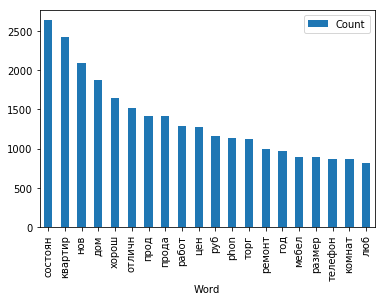

In [8]:
# Проверка на работу методов на тестовых данных + визуализация CountVectorizer
temp = frame(train, "description").toarray()

# Получаем кол-во встреч слов
dist = np.sum(temp, axis=0).tolist()
# Получаем сами слова
vocab = vectorizer.get_feature_names()

# Формируем фрейм
data_counts = pd.DataFrame([dist,vocab]).T
data_counts.columns=["Count","Word"]
data_counts = data_counts.sort_values("Count", ascending=False)
# График по первым 20 словам
data_counts.set_index('Word').iloc[:20].plot.bar()

In [9]:
# копирование на всяк случай. 
# df = data # реальные данные
df = train # тестовые, для счёта

In [10]:
###
### Полный процесс предобработки данных
###


# 1. Факторизация категориальных данных
df[CAT_COLS] = df[CAT_COLS].apply(lambda x: pd.factorize(x)[0])

# 2. Получение матриц BagOgWords
sparse_frames = [frame(df, i) for i in TARGET_COLUMNS]

# 3. Обучаем модель_1[] (модели) для каждой матрицы


# 4. Делаем предсказания модель_1[] каждой матрицы

# 5. Делаем сводную матрицу и добавляем столбцы категорий+доп.данных

# 7. По сводной матрице обучаем модель_2

# 8. По сводной матрице делаем предсказание модель_2

COLUMN: title
- Cleared
- Words extracted
- Processed

COLUMN: description
- Cleared
- Words extracted
- Processed

COLUMN: attrs
- Cleared
- Words extracted
- Processed

COLUMN: ['title', 'description']
- Cleared
- Words extracted
- Processed



In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV

temp = pd.DataFrame(sparse_frames[0].toarray())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [ ]:
params = list()

forest=RandomForestClassifier(n_estimators=10, random_state=SEED)
param_grid = {"max_depth": [3, None],
#               "max_features": [3, 10, 30, 40],
              "min_samples_split": [3, 5],
#               "min_samples_leaf": [3, 10],
#               "bootstrap": [True, False],
#               "criterion": ["gini", "entropy"]}
             }
i = 0
for fr in sparse_frames:
    print("##### Started: " + TARGET_COLUMNS[i])
    i += 1
    X = pd.DataFrame(fr.toarray())
    y = df.is_blocked
    grid_search = GridSearchCV(forest, param_grid=param_grid, verbose=1)
    grid_search.fit(X, y)
    params.append(grid_search.best_params_)

##### Started: title
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  1.5min finished


##### Started: description
Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [ ]:
clf = RandomForestClassifier(n_estimators=10)
scores = cross_val_score(clf, X_train, y_train, cv=5)
scores

In [ ]:
target.value_counts()

=9322/10000

In [ ]:
data_test = pd.DataFrame.from_csv('data/avito_test.tsv', sep='\t')
data_test.head(1)

In [ ]:
import sys
sys.path.append('./scripts')
import preprocessing

In [ ]:
df_title = pd.DataFrame(preprocessing.frame(train,"title").toarray())
df_desc = pd.DataFrame(preprocessing.frame(train,"description").toarray())
df_attrs = pd.DataFrame(preprocessing.frame(train,"attrs").toarray())